<a name='0'></a>

# MobileNets: Efficient Convolutional Neural Networks for Mobile Vision Applications


[MobileNet](https://arxiv.org/pdf/1704.04861v1.pdf) is an efficient network that is suited for mobile and embedded vision applications.

MobileNets uses depthwise separable convolutions which the author of the paper report they are efficient than normal convolutions. Depthwise separable convolutions are special type of grouped convolutions. We will see more about them later.

MobileNet can be used for various visual recognition tasks such as image classification and object detection. 

What's in here:

* [Introduction](#1)
* [Depthwise Separable Convolutions](#2)
* [MobileNet Architecture](#3)
* [Width and Resolution Multiplier](#4)
* [MobileNet implementation](#5)
* [Final Notes](#6)
* [Reference Implementations](#7)

<a name='1'></a>

## 1. Introduction

The very first convolutional neural network that demonstrated state of the art results is AlexNet.

Since AlexNet, ConvNets got bigger and bigger and that led to increased performance on various visual recognition tasks. The problem however is that there is a tradeoff between accuracy and latency and latency is an important factor in edge applications such as self-driving cars, robots, mobile phones, etc...

Due to its low latency, MobileNet is one of the most efficient network architectures for mobile-based visual applications.

MobileNet uses depthwise separable convolutions for improving the computationally efficient. Let's talk more about depthwise separable convolutions.

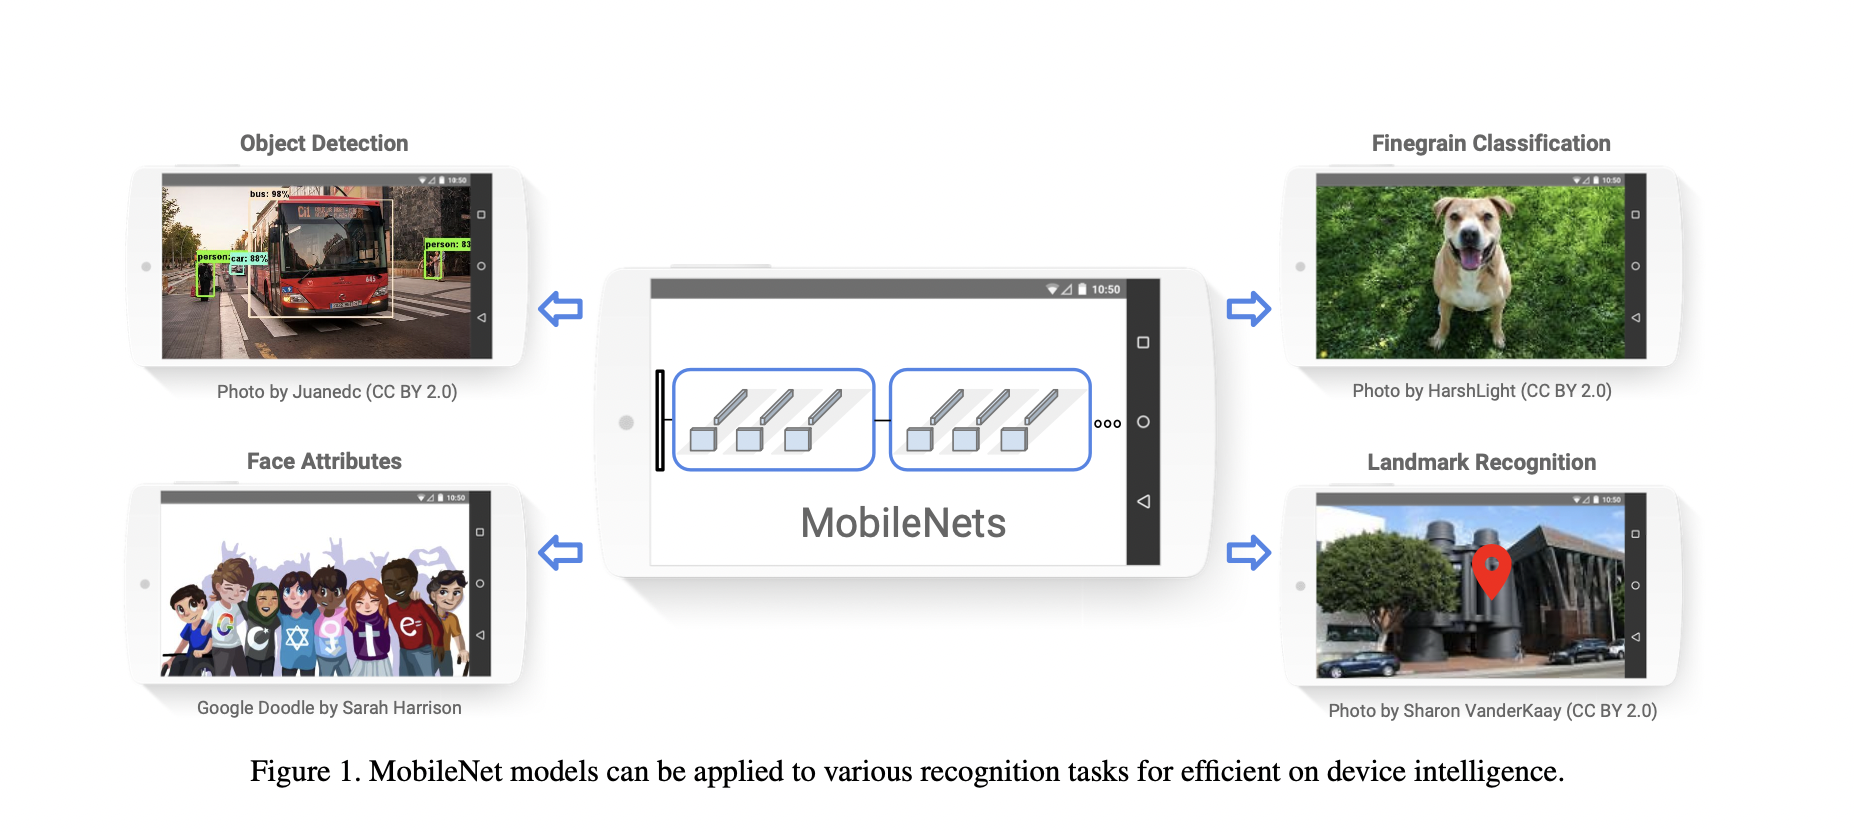

<a name='2'></a>
## 2. Depthwise Separable Convolutions

A depthwise separable convolution is a special kind of grouped convolutions that performs spatial convolutions on each independent channel, concatenate the results and apply 1x1 convolution(pointwise) to the results.

A Depthwise separable convolution is essentially made of depthwise(channel-wise) convolution and 1x1 convolution(point wise convolution). Depthwise or channel wise convolution applies a single filter to each input channel. Depthwise convolution is also similar to standard convolution whose groups are equal to the number of channels/filters. The pointwise or 1x1 convolution is used to combine the outputs of depthwise convolution layer. In essence, 1x1 convolution is equivalent to a fully connected layer(linear layer).

Depthwise separable convolution is simply the combination of depthwise or channel wise convolution and 1x1 convolution.

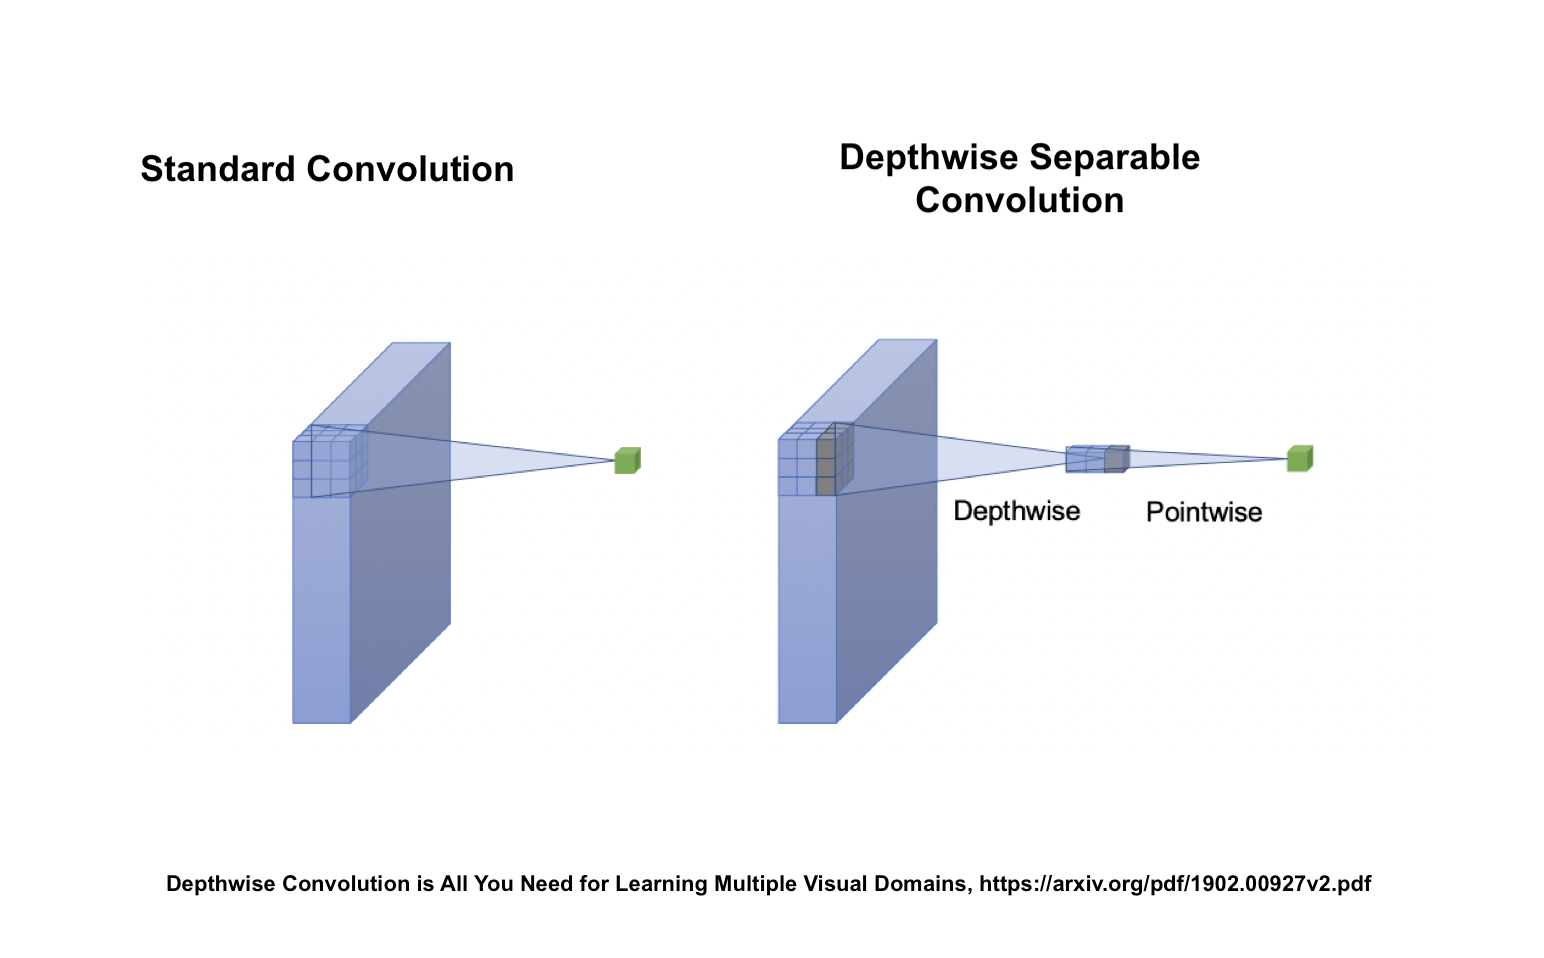

MobileNets use 3x3 depthwise seperable convolutions and as the authors reported, it is less computationally expensive than standard convolutions, up to between 8 & 9 times.

<a name='3'></a>

## 3. MobileNet Architecture

MobileNet is based on depthwise separable convolutions. 

In total, it has 28 depthwise and pointwise layers.

With the exception of the last fully connected layer, all layers are followed by batch normalization and ReLU non-linearity. To clarity that, in depthwise separable convolution, depthwise convolution and 1x1 convolution are followed by batch normalization and ReLU activation.

Downsampling is handled with the first standard convolutional layer and the strided depthwise convolution layers.

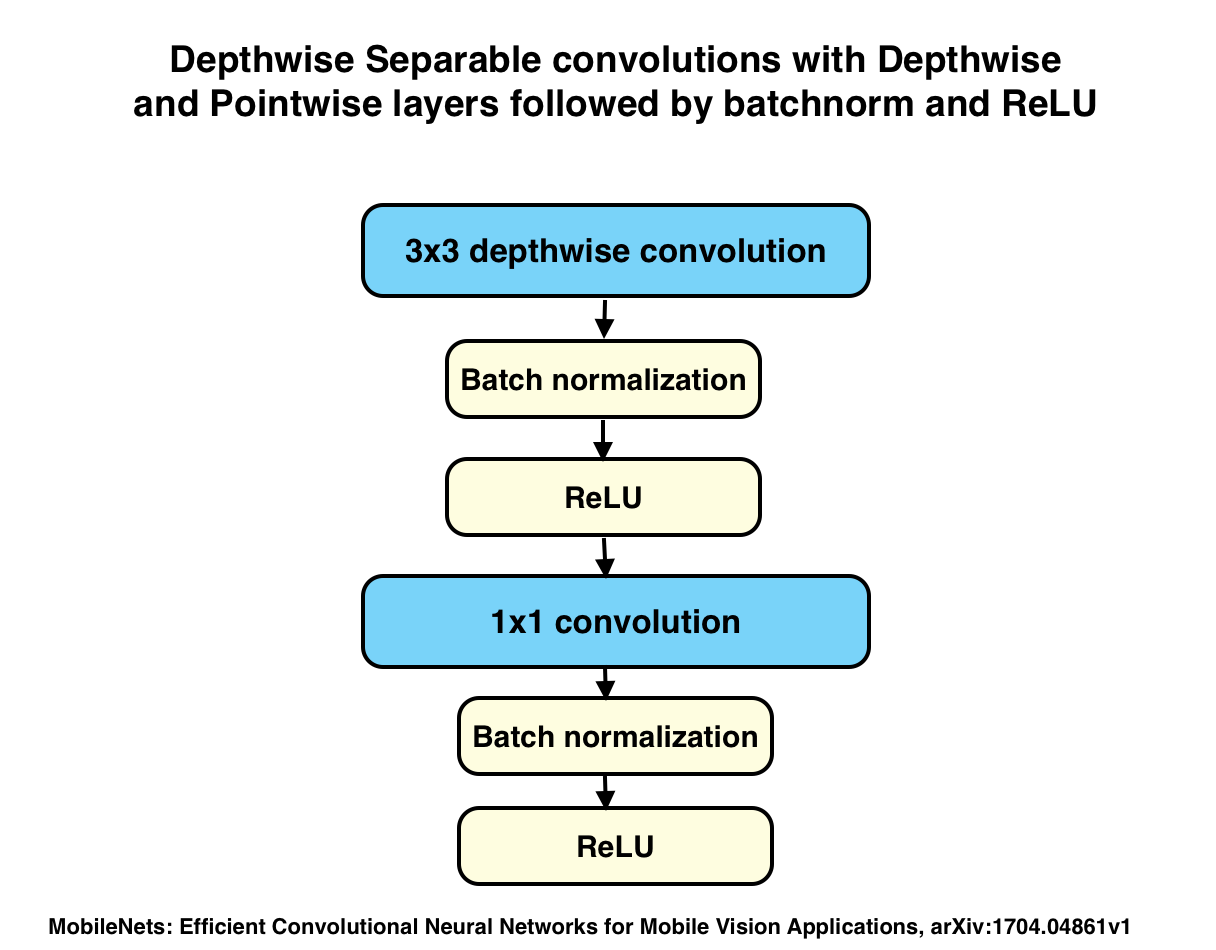

Below table depicts the architecture of MobileNet.

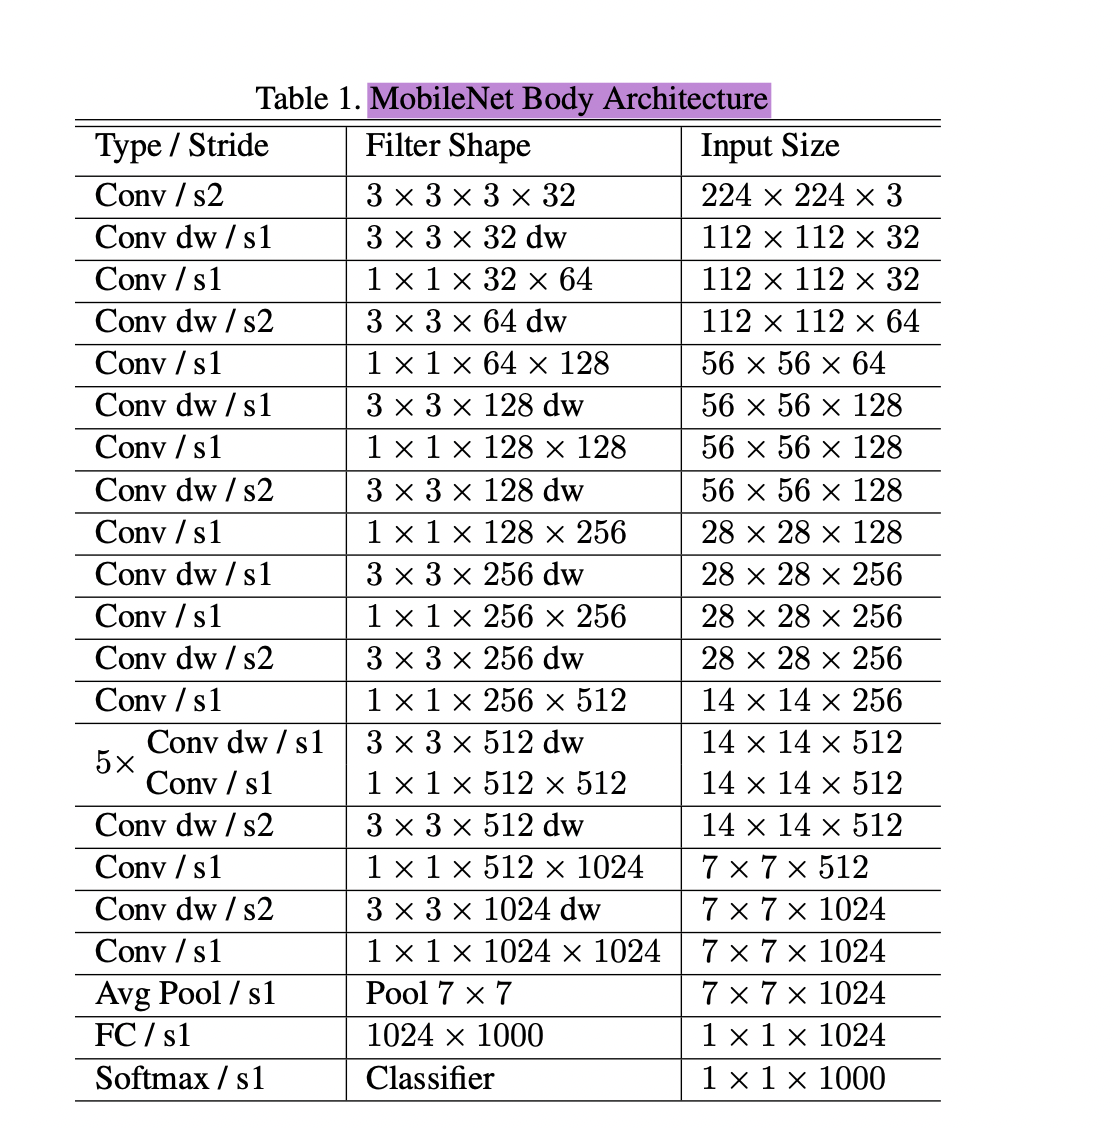

<a name='4'></a>

## 4. Width and Resolution Multipliers

Width multiplier `𝛼` is used to reduce the network uniformly at every layer. It is basically a number between 0 and 1 (typically 1, 0.75, 0.5, 0.25) that is multiplied on the channels(filters) in the standard and depthwise separable convolutions. In our implementation, we assume width multiplier to be 1. 

Using with multiplier reduces the computational cost and the number of parameters while still enjoying resonable accuracy, latency, and size trade-off.

Resolution multiplier `𝘱` is also used for reducing the computational cost and the number of parameters, but rather than reducing the channels in layers, it is applied on the input image and internal representation of every layer. Resolution multiplier is also a number between 0 and 1 but it is typically set so that the input resolutionn be 224, 192, 160 or 128. 

In our implementation, we will set both width and resolution multipliers to 1. Ofcourse the accuracy drops when you reduce the network (either by width & resolution) but you get reduced computational cost and parameters which is a resonable trade-off.



<a name='5'></a>
## 5. MobileNet Implementation

### Set Up

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

#### Depthwise Separabele Convolution Convolution Block

In [ ]:
def depthwise_block(input, filters, strides, padding='same'):
  """
  3x3 depthwise conv - batchnorm - relu - 1x1 conv - batchnorm - relu block
  
  Arguments:
  ---------
  input: input tensor
  filters: no of filters in depthwise convolution
  strides: no of strides in depthwise convolution
  padding: padding option in depthwise convolution
  """
  x = layers.DepthwiseConv2D(kernel_size=3, strides=strides, padding=padding)(input)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Conv2D(filters=filters, kernel_size=1, strides=1, padding='same')(x)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)

  return x

### Building the Whole MobileNet

In [ ]:
input = layers.Input(shape=(224, 224, 3))

#input downsampling stem
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(input)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

# depthwise separable convolutions blocks
x = depthwise_block(x, filters=32, strides=1)
x = depthwise_block(x, filters=64, strides=2)
x = depthwise_block(x, filters=128, strides=1)
x = depthwise_block(x, filters=128, strides=2)
x = depthwise_block(x, filters=256, strides=1)
x = depthwise_block(x, filters=256, strides=2)

# 5 repeated depthwise seperable conv blocks
for _ in range(5):
  x = depthwise_block(x, filters=512, strides=1)

x = depthwise_block(x, filters=1024, strides=2)
x = depthwise_block(x, filters=1024, strides=1)

# classification head
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(units=1000, activation='softmax')(x)

mobilenet = keras.Model(input, output)

In [ ]:
mobilenet.summary()

Model: "model_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_417 (Conv2D)         (None, 112, 112, 32)      896       
                                                                 
 batch_normalization_761 (Ba  (None, 112, 112, 32)     128       
 tchNormalization)                                               
                                                                 
 re_lu_760 (ReLU)            (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d_375 (Depth  (None, 112, 112, 32)     320       
 wiseConv2D)                                                     
                                                                 
 batch_normalization_762 (Ba  (None, 112, 112, 32)     128

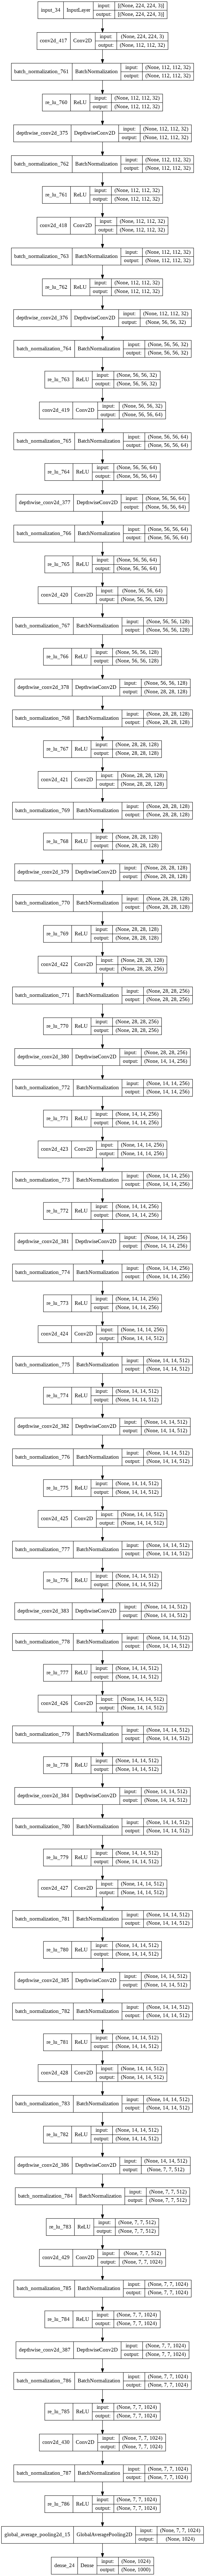

In [ ]:
keras.utils.plot_model(mobilenet, show_shapes=True)

<a name='6'></a>
## 6. Final Notes

MobileNet is a computationally efficient network that is based on depthwise separable convolutions. Depthwise separable convolutions are combination of depthwise convolutions and 1x1 pointwise convolutions. They perform spatial convolution on each independent channel, concatenate the results and apply 1x1 convolution to the results.

MobileNet also achieved excellent results on other tasks beyond ImageNet classification such as fine grained classification, large scale geolocalizaton(determining where on earth a photo was taken as a classification problem), face attributes classification, and object detection.

The orginal MobileNet uses depthwise separable convolutions. The second version [MobileNetV2](https://arxiv.org/pdf/1801.04381.pdf) is similar to orginal MobileNet but it uses inverted residual blocks and linear bottlenecks. The third version [MobileNetV3](https://arxiv.org/pdf/1905.02244.pdf) is based on Neural Architecture Search(NAS).

<a name='7'></a>

## 7. References Implementation

* [Keras Applications, MobileNet](https://github.com/keras-team/keras-applications/blob/master/keras_applications/mobilenet.py)

### [BACK TO TOP](#0)